In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.api as smt

In [155]:
df = pd.read_pickle('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/the_df.pickle')
holidays = pd.read_pickle('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/the_holidays.pickle')
tokyo_weather = pd.read_pickle('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/tokyo_weather.pickle')
air_reserve = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/air_reserve.csv')

In [10]:
tokyo_shibuya = df.loc[(df['air_area_name']=='Tōkyō-to Shibuya-ku Shibuya')]

In [48]:
tokyo_shibuya['air_store_id'].value_counts().head()

air_5c65468938c07fa5    478
air_25d8e5cc57dd87d9    478
air_5c817ef28f236bdf    477
air_9f277fb7a2c1d842    476
air_707d4b6328f2c2df    475
Name: air_store_id, dtype: int64

In [98]:
restaurant1 = tokyo_shibuya.loc[(tokyo_shibuya['air_store_id']=='air_25d8e5cc57dd87d9')]

In [99]:
forecast_holidays = holidays[478:]
forecast_tokyo_weather = tokyo_weather[478:]
forecast_tokyo_weather['visit_date'] = pd.to_datetime(forecast_tokyo_weather['calendar_date'])
forecast = pd.merge(forecast_holidays, forecast_tokyo_weather, on='visit_date', how='inner').fillna(0)

//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
forecast['is_weekday'] = (forecast['visit_date'].dt.weekday < 5).astype(int)
forecast['is_weekend'] = (forecast['visit_date'].dt.weekday > 4).astype(int)
restaurant1['log1p_visitors'] = np.log1p(restaurant1['visitors'])
restaurant1 = restaurant1.set_index('visit_date')

//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [101]:
y1 = restaurant1['log1p_visitors'].dropna()

train1 = y1[:466]
test1 = y1[466:]
len(test1)

12

In [102]:
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test Statistic         -5.698264e+00
p-value                 7.782741e-07
Lags Used               1.400000e+01
Observations Used       4.630000e+02
Critical Value (1%)    -3.444553e+00
Critical Value (5%)    -2.867803e+00
Critical Value (10%)   -2.570106e+00
dtype: float64


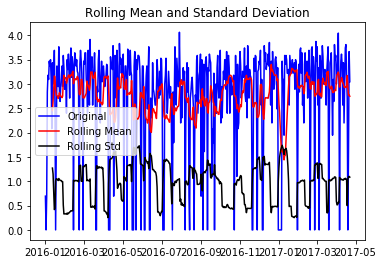

In [103]:
dftest(y1)

In [104]:
restaurant1.columns

Index(['air_store_id', 'visitors', 'day_of_week', 'is_holiday',
       'prev_day_was_holiday', 'next_day_is_holiday', 'low_impact_holiday',
       'high_impact_holiday', 'weekend_holiday', 'is_weekday', 'is_weekend',
       'year', 'month', 'air_genre_name', 'air_area_name', 'latitude',
       'longitude', 'latitude_str', 'longitude_str', 'station_id',
       'station_latitude', 'station_longitude', 'station_vincenty',
       'station_great_circle', 'calendar_date', 'precipitation',
       'avg_temperature', 'total_snowfall', 'deepest_snowfall',
       'hours_sunlight', 'avg_wind_speed', 'avg_vapor_pressure',
       'avg_humidity', 'avg_sea_pressure', 'avg_local_pressure',
       'solar_radiation', 'cloud_cover', 'high_temperature', 'low_temperature',
       'log1p_visitors'],
      dtype='object')

In [105]:
exog = restaurant1[[ 'day_of_week', 'is_holiday',
       'prev_day_was_holiday', 'next_day_is_holiday', 'low_impact_holiday',
       'high_impact_holiday', 'weekend_holiday', 'is_weekday', 'is_weekend',
       'year', 'month']]
train_exog = exog[:466]
test_exog = exog[466:]
forecast_exog = forecast[[ 'day_of_week', 'is_holiday',
       'prev_day_was_holiday', 'next_day_is_holiday', 'low_impact_holiday',
       'high_impact_holiday', 'weekend_holiday', 'is_weekday', 'is_weekend',
       'year', 'month']]
forecast_exog = pd.concat([test_exog, forecast_exog], ignore_index=True)

In [106]:
p = range(1,3)
d = range(0,2)
q = range(1,3)
sp = range(0,2)
sd = range(1,2)
sq = range(1,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(sp, sd, sq))]

In [109]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train1,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            exog=train_exog,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 7)12 - AIC:1236.385614115995


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 7)12 - AIC:1237.1636772452716


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 1, 1, 7)12 - AIC:1229.5186747667817


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 1, 1, 7)12 - AIC:1231.026839141675


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 7)12 - AIC:1238.965206094745


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 7)12 - AIC:1242.5087103181877


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 1, 1, 7)12 - AIC:1240.3306298665434


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 1, 1, 7)12 - AIC:1241.9785628414666
ARIMA(2, 0, 1)x(0, 1, 1, 7)12 - AIC:1246.2310858748624


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 1, 1, 7)12 - AIC:1238.9754126798052


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 1, 1, 7)12 - AIC:1228.5187706159059


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 1, 1, 7)12 - AIC:1231.7713662042352


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 1, 1, 7)12 - AIC:1242.7572237417698


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 1, 7)12 - AIC:1244.5545382668602


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 1, 1, 7)12 - AIC:1240.029143440423
ARIMA(2, 1, 2)x(1, 1, 1, 7)12 - AIC:1244.441440802772


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [110]:
mod = sm.tsa.statespace.SARIMAX(endog=train1,
                                order=(2, 0, 2),
                                seasonal_order=(0, 1, 1, 7),
                                exog=train_exog,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
day_of_week          -4.662e-07      4e-08    -11.648      0.000   -5.45e-07   -3.88e-07
is_holiday              -0.6655      0.223     -2.983      0.003      -1.103      -0.228
prev_day_was_holiday    -0.2132      0.201     -1.060      0.289      -0.607       0.181
next_day_is_holiday      0.1728      0.211      0.818      0.413      -0.241       0.587
low_impact_holiday      -2.0788   8.36e-09  -2.49e+08      0.000      -2.079      -2.079
high_impact_holiday     -0.6467      0.284     -2.275      0.023      -1.204      -0.090
weekend_holiday         -0.9334      0.302     -3.094      0.002      -1.525      -0.342
is_weekday           -6.261e-07   1.47e-08    -42.643      0.000   -6.55e-07   -5.97e-07
is_weekend           -7.847e-07   6.67e-09   -117.632      0.000   -7.98e-07   -7.72e-07
year                 

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


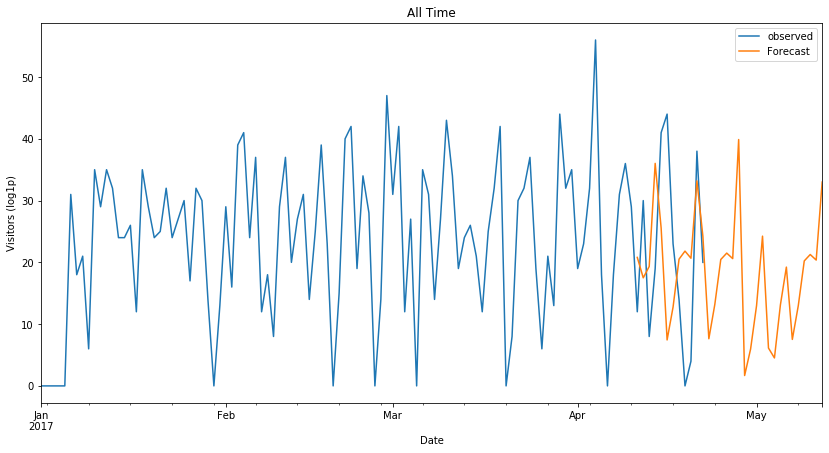

In [113]:
pred_uc = results.get_forecast(steps=32, exog=forecast_exog[:32])
pred_ci = pred_uc.conf_int()
ax = np.expm1(y1['2017':]).plot(label='observed', figsize=(14, 7))
np.expm1(pred_uc.predicted_mean).plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors (log1p)')
plt.title('All Time')
plt.legend()
plt.show()

In [112]:
y_forecasted = np.expm1(results.get_forecast(steps=14, exog=forecast_exog[:14]).predicted_mean)
y_truth = np.expm1(test1)
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE: ', mse)
print('RMSE: ', np.sqrt(mse))

MSE:  264.10884027052293
RMSE:  16.251425791927396


In [141]:
tableau1 = pd.DataFrame(holidays['visit_date'][:498])

In [142]:
tableau1.set_index('visit_date', inplace=True)

In [143]:
tableau1['y'] = restaurant1['visitors']

In [149]:
tableau1['yhat'] = pd.DataFrame(np.expm1((results.get_forecast(steps=32, exog=forecast_exog[:32])).predicted_mean))

In [151]:
tableau1.reset_index()

,visit_date,y,yhat
0,2016-01-01,1.0,NaN
1,2016-01-02,0.0,NaN
2,2016-01-03,1.0,NaN
3,2016-01-04,16.0,NaN
4,2016-01-05,23.0,NaN
...,...,...,...
493,2017-05-08,NaN,12.998483
494,2017-05-09,NaN,20.235031
495,2017-05-10,NaN,21.270021
496,2017-05-11,NaN,20.371926


In [153]:
tableau1.to_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/restaurant1_forecast.csv')

In [154]:
restaurant1

,air_store_id,visitors,day_of_week,is_holiday,prev_day_was_holiday,next_day_is_holiday,low_impact_holiday,high_impact_holiday,weekend_holiday,is_weekday,...,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature,log1p_visitors
visit_date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,air_25d8e5cc57dd87d9,1,4,1,0.0,1.0,1.0,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147
2016-01-02,air_25d8e5cc57dd87d9,0,5,1,1.0,1.0,0.0,1.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2016-01-03,air_25d8e5cc57dd87d9,1,6,1,1.0,0.0,0.0,1.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147
2016-01-04,air_25d8e5cc57dd87d9,16,0,0,1.0,0.0,0.0,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.833213
2016-01-05,air_25d8e5cc57dd87d9,23,1,0,0.0,0.0,0.0,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.178054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-18,air_25d8e5cc57dd87d9,14,1,0,0.0,0.0,0.0,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.708050
2017-04-19,air_25d8e5cc57dd87d9,0,2,0,0.0,0.0,0.0,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2017-04-20,air_25d8e5cc57dd87d9,4,3,0,0.0,0.0,0.0,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.609438


In [156]:
air_reserve.loc[(air_reserve['air_store_id']=='air_25d8e5cc57dd87d9')]

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
